# Bias Removal

Climate models can have biases relative to different verification datasets. Commonly, biases are removed by postprocessing before verification of forecasting skill. `climpred` provides convenience functions to do so.

---

The select from following methods by specifying `how` in [HindcastEnsemble.remove_bias](api/climpred.classes.HindcastEnsemble.remove_bias.html#climpred.classes.HindcastEnsemble.remove_bias):

- ``how="additive_mean"``: correcting the mean forecast additively (already implemented)
- ``how="multiplicative_mean"``: correcting the mean forecast multiplicatively
- ``how="multiplicative_std"``: correcting the standard deviation multiplicatively

Wrapped from the github package [bias_correction](https://github.com/pankajkarman/bias_correction/blob/master/bias_correction.py):

- ``how="modified_quantile"``: [Reference](https://www.sciencedirect.com/science/article/abs/pii/S0034425716302000?via%3Dihub)
- ``how="basic_quantile"``: [Reference](https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/joc.2168)
- ``how="gamma_mapping"``: [Reference](https://www.hydrol-earth-syst-sci.net/21/2649/2017)
- ``how="normal_mapping"``: [Reference](https://www.hydrol-earth-syst-sci.net/21/2649/2017)

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
import climpred
import xarray as xr
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble

<IPython.core.display.Javascript object>

In [3]:
init = climpred.tutorial.load_dataset("NMME_hindcast_Nino34_sst")
obs = climpred.tutorial.load_dataset("NMME_OIv2_Nino34_sst")
v = "sst"

<IPython.core.display.Javascript object>

/Users/aaron.spring/Coding/climpred/climpred/checks.py:236: UserWarning: Did not find dimension "init", but renamed dimension S with CF-complying standard_name "forecast_reference_time" to init.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:236: UserWarning: Did not find dimension "member", but renamed dimension M with CF-complying standard_name "realization" to member.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:236: UserWarning: Did not find dimension "lead", but renamed dimension L with CF-complying standard_name "forecast_period" to lead.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='OIv2 SST [Celsius_scale]'>

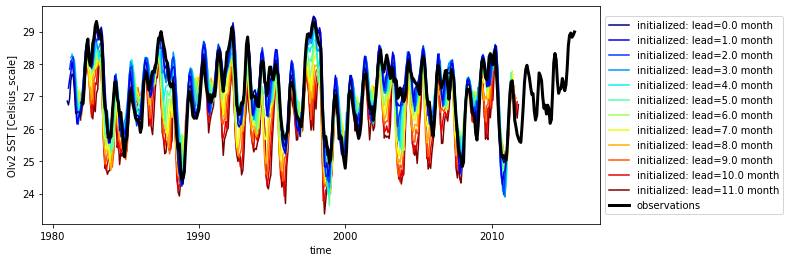

<IPython.core.display.Javascript object>

In [4]:
hindcast = HindcastEnsemble(init.isel(model=4)).add_observations(obs)
hindcast.plot()

The warming of the `observations` is similar to `initialized`.

## Additive mean bias removal

Typically, bias depends on lead-time and therefore should therefore also be removed depending on `lead`.

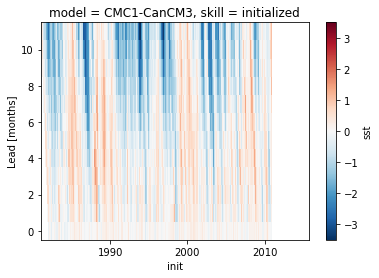

<IPython.core.display.Javascript object>

In [5]:
bias = hindcast.verify(metric="bias", comparison="e2o", dim=[], alignment="same_verifs")

bias[v].plot()

In [6]:
# group bias by seasonality
seasonality = climpred.options.OPTIONS["seasonality"]
seasonality

'month'

<IPython.core.display.Javascript object>

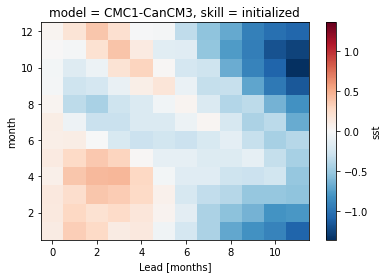

<IPython.core.display.Javascript object>

In [7]:
bias.groupby(f"init.{seasonality}").mean()[v].plot()

An initial warm bias develops into a cold bias, especially in winter.

### Cross Validatation
To remove the additive mean bias quickly, the mean bias over all initializations is subtracted. For bias removal with cross validation, the given initialization is [left out](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) when subtracting the mean bias.

`climpred` wraps these functions in `HindcastEnsemble.remove_bias(alignment, how=how, cross_validate={False, 'LOO'})`.

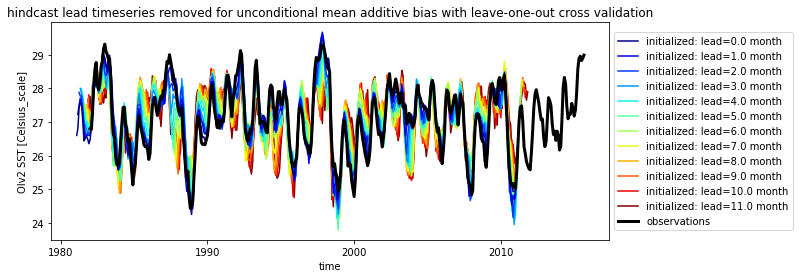

<IPython.core.display.Javascript object>

In [8]:
hindcast.remove_bias(
    how="additive_mean", cross_validate="LOO", alignment="same_verifs"
).plot()
plt.title(
    "hindcast lead timeseries removed for unconditional mean additive bias with leave-one-out cross validation"
)
plt.show()

## Skill

Distance-based accuracy metrics like (`mse`,`rmse`,`nrmse`,...) are sensitive to mean bias removal. Correlations like (`pearson_r`, `spearman_r`) are insensitive to mean bias correction.

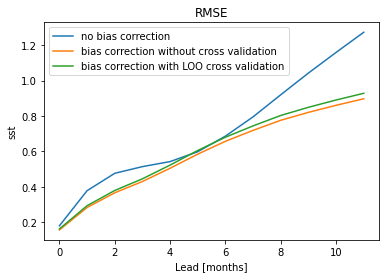

<IPython.core.display.Javascript object>

In [9]:
metric_kwargs = dict(
    metric="rmse", alignment="same_verifs", dim="init", comparison="e2o", skipna=True
)
hindcast.verify(**metric_kwargs)[v].plot(label="no bias correction")
hindcast.remove_bias(
    how="additive_mean", cross_validate=False, alignment=metric_kwargs["alignment"]
).verify(**metric_kwargs)[v].plot(label="bias correction without cross validation")
hindcast.remove_bias(
    how="additive_mean", cross_validate="LOO", alignment=metric_kwargs["alignment"]
).verify(**metric_kwargs)[v].plot(label="bias correction with LOO cross validation")
plt.legend()
plt.title(f"{metric_kwargs['metric'].upper()}")
plt.show()